In [1]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # descision trees 
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix # model stats

Enable Pandas **progress_apply**

In [2]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [3]:
def calc_descriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

Read data from ["ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure"](https://pubs.acs.org/doi/10.1021/ci034243x)

In [4]:
df = pd.read_csv("delaney.csv")

Get the dataframe column names

In [5]:
df.columns

Index(['Compound ID', 'measured log(solubility:mol/L)',
       'ESOL predicted log(solubility:mol/L)', 'SMILES'],
      dtype='object')

Change the name of column 1 to "LogS"

In [6]:
cols = list(df.columns)
cols[1] = 'LogS'
df.columns = cols

Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM

In [7]:
df['IsSol'] = df.LogS > math.log10(200 * 1e-6)

Plot solubility as a sanity check

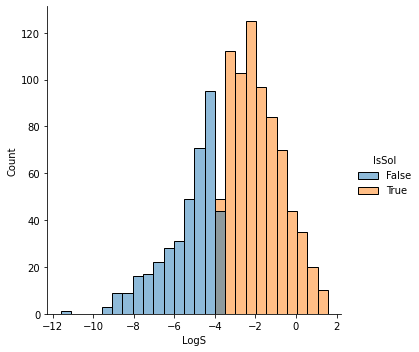

In [8]:
sns.displot(x='LogS',hue="IsSol",data=df)

Add the descriptors to the dataframe.  Note that all of the descriptors are going into one column called "desc".

In [9]:
df['desc'] = df.SMILES.progress_apply(calc_descriptors)

100%|██████████| 1144/1144 [00:00<00:00, 1870.04it/s]


Split the descriptors into their on own columns.

In [10]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
df[desc_cols] = df.desc.to_list()

We no longer need the "desc" column, let's get rid of it. 

In [11]:
df.drop("desc",axis=1,inplace=True)

Let's check the dataframe to make sure it's ok. 

In [12]:
df

,Compound ID,LogS,ESOL predicted log(solubility:mol/L),SMILES,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl,True,167.850,2.59540,0,0,0
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl,True,133.405,2.37650,0,0,0
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl,True,167.850,2.59380,0,0,0
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl,True,133.405,2.02890,0,0,0
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl,True,187.375,2.91890,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC),True,287.343,1.98820,0,1,6
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,False,286.114,3.42130,1,0,3
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,False,308.333,3.60960,3,1,4
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,False,354.815,2.56214,2,3,4


Split the data into training and test sets. 

In [13]:
train, test = train_test_split(df)

Split the training and test sets into X and y variables. 

In [14]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

Create and train a classifier

In [15]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

Predict on the test set

In [16]:
pred = cls.predict(test_X)
roc_auc_score(test_y, pred)

0.8502066685037201

Plot a confusion matrix to show the classifier performance

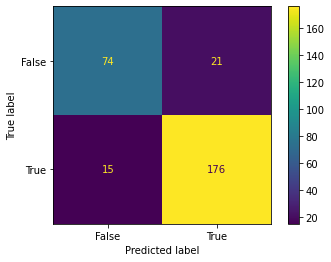

In [18]:
plot_confusion_matrix(cls,test_X,test_y)

In [46]:
Plot an ROC cure to show the classifier performance

SyntaxError: invalid syntax (<ipython-input-46-f6efcaa885a7>, line 1)

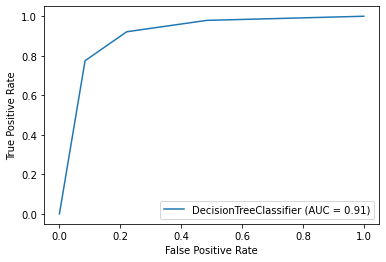

In [19]:
plot_roc_curve(cls,test_X,test_y)

Use the default view from SciKit Learn to plot the decision tree

[Text(279.0, 453.0, 'LogP <= 3.127\ngini = 0.455\nsamples = 858\nvalue = [300, 558]'),
 Text(139.5, 271.8, 'MW <= 229.197\ngini = 0.198\nsamples = 600\nvalue = [67, 533]'),
 Text(69.75, 90.59999999999997, 'gini = 0.101\nsamples = 468\nvalue = [25, 443]'),
 Text(209.25, 90.59999999999997, 'gini = 0.434\nsamples = 132\nvalue = [42, 90]'),
 Text(418.5, 271.8, 'LogP <= 3.742\ngini = 0.175\nsamples = 258\nvalue = [233, 25]'),
 Text(348.75, 90.59999999999997, 'gini = 0.386\nsamples = 88\nvalue = [65, 23]'),
 Text(488.25, 90.59999999999997, 'gini = 0.023\nsamples = 170\nvalue = [168, 2]')]

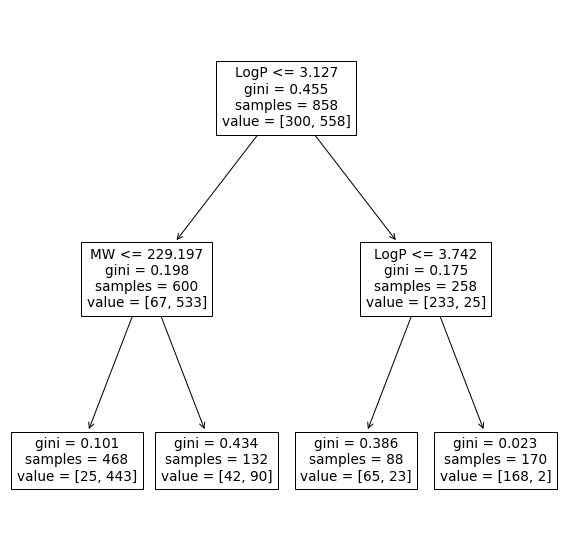

In [20]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

Use dtreeviz to plot the decision tree

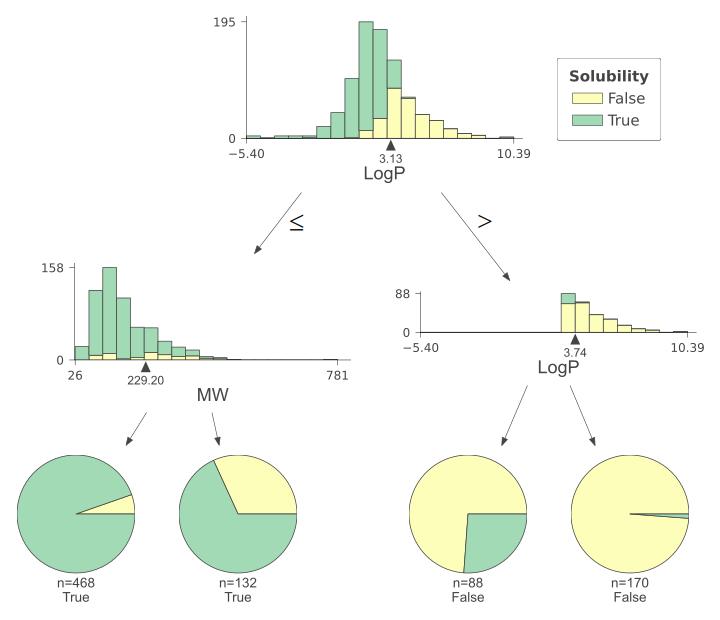

In [21]:
viz = dtreeviz(cls, train_X, train_y, feature_names = desc_cols, 
               target_name = "Solubility",class_names=["False","True"],scale=2)
viz

As a final check we're going to see if we can fit a model to incorrect data.  If we shuffle the y values, we shouldn't be able to get a good model. 

Shuffle the y-variable as a sanity check

In [26]:
df['fake'] = df.IsSol.sample(frac=1)

Split the dataframe into training a test sets. 

In [27]:
fake_train, fake_test = train_test_split(df)

Split the training and test sets into X and y variables

In [29]:
fake_train_X = fake_train[desc_cols]
fake_train_y = fake_train.fake
fake_test_X = fake_test[desc_cols]
fake_test_y = fake_test.fake

Build a classifer

In [30]:
fake_cls = DecisionTreeClassifier(max_depth=2)
fake_cls.fit(fake_train_X,fake_train_y)

DecisionTreeClassifier(max_depth=2)

Generate the predictions

In [40]:
fake_pred = fake_cls.predict(fake_test_X)

Calculate the AUC score

In [41]:
roc_auc_score(fake_test_y,pred)

0.44254210992907794